## Este notebook es encargado de implementar un modelo para realizar la predicción del estado emocional de una sesión de prueba

In [59]:
import pickle
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np

In [60]:
model = pickle.load(open('./models/model', 'rb'))
# result_val = model.score(xval, yval)
# result_test = model.score(xtest, ytest)

In [69]:
df_1 = pd.read_csv("..//resources//csv//data//sujeto1-rocio-2020-10-25-biometrics.csv")
df_2 = pd.read_csv("..//resources//csv//data//sujeto2-juan-2020-11-01-biometrics.csv")
df_3 = pd.read_csv("..//resources//csv//data//sujeto3-brenda-2020-11-16-biometrics.csv")
df_4 = pd.read_csv("..//resources//csv//data//sujeto4-matias-2020-11-16-biometrics.csv")
df_5 = pd.read_csv("..//resources//csv//data//sujeto5-sebastian-2021-01-05-biometrics.csv")
df_6 = pd.read_csv("..//resources//csv//data//sujeto6-rocio-2021-01-07-biometrics.csv")

df_to_predict = df_5

df_to_predict.head()

,TimeStamp,HR,RR,HRV,MicroSiemens,SCR,SCR_MIN,ArousalMean,ValenceMean,ArousalSD,ValenceSD,PhaseName,MatchesSam
0,2021-01-05 20:56:57,83.7,717,0.1,2.75,0,0,0.0,0.0,0.0,0.0,NaN,False
1,2021-01-05 20:56:58,83.1,722,0.0,2.70,0,0,0.0,0.0,0.0,0.0,NaN,False
2,2021-01-05 20:56:59,81.2,739,0.0,2.68,0,0,0.0,0.0,0.0,0.0,NaN,False
3,2021-01-05 20:56:59,84.0,714,0.0,2.66,0,0,0.0,0.0,0.0,0.0,NaN,False
4,2021-01-05 20:57:00,83.8,716,0.0,2.66,0,0,0.0,0.0,0.0,0.0,NaN,False


In [70]:
def add_prev_values(df, col):
    df.loc[0, f'{col}-4'] = df.loc[0, col]
    df.loc[0, f'{col}-3'] = df.loc[0, col]
    df.loc[0, f'{col}-2'] = df.loc[0, col]
    df.loc[0, f'{col}-1'] = df.loc[0, col]

    for i in range(0, len(df)):
        if i >= 4:
            df.loc[i, f'{col}-4'] = df.loc[i-4, col]
            df.loc[i, f'{col}-3'] = df.loc[i-3, col]
            df.loc[i, f'{col}-2'] = df.loc[i-2, col]
            df.loc[i, f'{col}-1'] = df.loc[i-1, col]
        else:
            df.loc[i, f'{col}-4'] = df.loc[i, col]
            df.loc[i, f'{col}-3'] = df.loc[i, col]
            df.loc[i, f'{col}-2'] = df.loc[i, col]
            df.loc[i, f'{col}-1'] = df.loc[i, col]

In [71]:
# Función que determina cuando un sujeto se encuentra en un estado de excitación (1) o relajación (0) dado un valor de arousal.
def isAroused(arousal):
    return 0 if arousal < 5 else 1

In [72]:
df_to_standarize = df_to_predict.copy()
    
# Se remueven las mediciones sin estímulo (previas al inicio de estímulos), para no ofuscar el entrenamiento
filterNoArousalMeasurements = df_to_standarize['ArousalMean'] > 0
df_to_standarize = df_to_standarize[filterNoArousalMeasurements]

# remover las mediciones para las que el sam no coincidió antes de la estandarización, para no afectar la desviación
# filterNoMatchesSAMMeasurements = filtered1['MatchesSam'] == True
# df_to_standarize = df_to_standarize[filterNoMatchesSAMMeasurements]

# Se agrega la columna Aroused (0/1) para la clasificación binaria
df_to_standarize['Aroused'] = df_to_standarize['ArousalMean'].map(isAroused)

columns_to_standarize = ['HR', 'RR', 'HRV', 'MicroSiemens']

scaler = preprocessing.StandardScaler()
standarized_df = scaler.fit_transform(df_to_standarize[columns_to_standarize])

standarized_df_with_rest_of_data = np.append(standarized_df, df_to_standarize[['SCR', 'SCR_MIN', 'PhaseName', 'ArousalMean', 'Aroused', 'TimeStamp']], axis=1)

# Se convierte a DataFrame
standarized_df_with_rest_of_data = pd.DataFrame(standarized_df_with_rest_of_data, columns=['HR', 'RR', 'HRV', 'MicroSiemens', 'SCR', 'SCR_MIN', 'PhaseName', 'ArousalMean', 'Aroused', 'TimeStamp'])

# Conversión de tipos
standarized_df_with_rest_of_data['HR'] = standarized_df_with_rest_of_data['HR'].astype(float)
standarized_df_with_rest_of_data['RR'] = standarized_df_with_rest_of_data['RR'].astype(float)
standarized_df_with_rest_of_data['HRV'] = standarized_df_with_rest_of_data['HRV'].astype(float)
standarized_df_with_rest_of_data['MicroSiemens'] = standarized_df_with_rest_of_data['MicroSiemens'].astype(float)
standarized_df_with_rest_of_data['SCR'] = standarized_df_with_rest_of_data['SCR'].astype(int)
standarized_df_with_rest_of_data['SCR_MIN'] = standarized_df_with_rest_of_data['SCR_MIN'].astype(int)
standarized_df_with_rest_of_data['PhaseName'] = standarized_df_with_rest_of_data['PhaseName']
standarized_df_with_rest_of_data['ArousalMean'] = standarized_df_with_rest_of_data['ArousalMean'].astype(float)
standarized_df_with_rest_of_data['Aroused'] = standarized_df_with_rest_of_data['Aroused'].astype(int)
standarized_df_with_rest_of_data['Aroused'] = standarized_df_with_rest_of_data['Aroused'].astype(int)
standarized_df_with_rest_of_data['TimeStamp'] = standarized_df_with_rest_of_data['TimeStamp']

standarized_df_with_rest_of_data

add_prev_values(standarized_df_with_rest_of_data, "HR")
add_prev_values(standarized_df_with_rest_of_data, "HRV")
add_prev_values(standarized_df_with_rest_of_data, "MicroSiemens")

df_to_predict = standarized_df_with_rest_of_data
df_to_predict

,HR,RR,HRV,MicroSiemens,SCR,SCR_MIN,PhaseName,ArousalMean,Aroused,TimeStamp,...,HR-2,HR-1,HRV-4,HRV-3,HRV-2,HRV-1,MicroSiemens-4,MicroSiemens-3,MicroSiemens-2,MicroSiemens-1
0,-1.541891,1.665147,2.171295,-0.509401,0,5,HA_PV_9,6.230769,1,2021-01-05 20:58:25,...,-1.541891,-1.541891,2.171295,2.171295,2.171295,2.171295,-0.509401,-0.509401,-0.509401,-0.509401
1,-1.409599,1.505850,2.076795,-0.656249,0,5,HA_PV_9,6.230769,1,2021-01-05 20:58:25,...,-1.409599,-1.409599,2.076795,2.076795,2.076795,2.076795,-0.656249,-0.656249,-0.656249,-0.656249
2,-1.145015,1.187257,2.010824,-0.773727,0,5,HA_PV_9,6.230769,1,2021-01-05 20:58:26,...,-1.145015,-1.145015,2.010824,2.010824,2.010824,2.010824,-0.773727,-0.773727,-0.773727,-0.773727
3,0.310198,-0.360194,1.969814,-0.803097,0,5,HA_PV_9,6.230769,1,2021-01-05 20:58:27,...,0.310198,0.310198,1.969814,1.969814,1.969814,1.969814,-0.803097,-0.803097,-0.803097,-0.803097
4,0.111759,-0.178141,1.946635,-0.920575,1,5,HA_PV_9,6.230769,1,2021-01-05 20:58:28,...,-1.145015,0.310198,2.171295,2.076795,2.010824,1.969814,-0.509401,-0.656249,-0.773727,-0.803097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,-1.078869,1.118987,-0.619125,0.782858,0,1,HA_NV_16,7.000000,1,2021-01-05 21:07:55,...,0.464538,0.001516,-0.654785,-0.888360,-0.956115,-0.783162,0.812228,0.797543,0.768174,0.738804
665,-1.563940,1.687903,-0.406946,1.663945,0,1,HA_NV_16,7.000000,1,2021-01-05 21:07:56,...,0.001516,-1.078869,-0.888360,-0.956115,-0.783162,-0.619125,0.797543,0.768174,0.738804,0.782858
666,-1.100918,1.141744,-0.314229,2.045749,0,1,HA_NV_16,7.070000,1,2021-01-05 21:07:57,...,-1.078869,-1.563940,-0.956115,-0.783162,-0.619125,-0.406946,0.768174,0.738804,0.782858,1.663945
667,-0.858382,0.868664,-0.289267,1.546467,0,1,HA_NV_16,7.070000,1,2021-01-05 21:07:58,...,-1.563940,-1.100918,-0.783162,-0.619125,-0.406946,-0.314229,0.738804,0.782858,1.663945,2.045749


In [73]:
y_pred = model.predict(df_to_predict[['MicroSiemens', 'HR', 'HRV', 'MicroSiemens-4', 'MicroSiemens-3', 'MicroSiemens-2', 'MicroSiemens-1', 'HR-4', 'HR-3', 'HR-2', 'HR-1', 'HRV-4','HRV-3','HRV-2','HRV-1']].values)

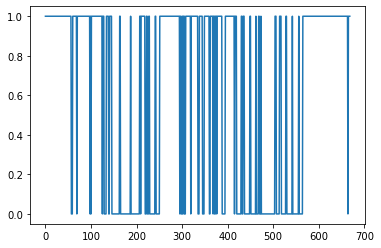

In [74]:
plt.plot(y_pred)
plt.show()

In [75]:
model.score(df_to_predict[['MicroSiemens', 'HR', 'HRV', 'MicroSiemens-4', 'MicroSiemens-3', 'MicroSiemens-2', 'MicroSiemens-1', 'HR-4', 'HR-3', 'HR-2', 'HR-1', 'HRV-4','HRV-3','HRV-2','HRV-1']], df_to_predict[['Aroused']])

0.828101644245142

In [68]:
df_to_predict['ArousalPred'] = y_pred

df_to_predict.to_csv(r'./3_prediction.csv', date_format='%s', index = False)